In [1]:
import re
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
import matplotlib.pyplot as plt

from collections import Counter

from tensorflow import keras
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.python.keras import models, layers, optimizers
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Dense, Flatten, Conv1D, MaxPooling1D, LSTM, GRU, Embedding,\
    GlobalAveragePooling1D, BatchNormalization, LeakyReLU, Dropout

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import PassiveAggressiveClassifier
from sklearn.metrics import accuracy_score, confusion_matrix

import nltk
nltk.download('punkt')
nltk.download('stopwords')
from nltk.corpus import stopwords

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\indiz\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\indiz\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [2]:
true_data = pd.read_csv('..\Dataset\True.csv', engine='python', encoding='utf-8')
fake_data = pd.read_csv('..\Dataset\Fake.csv', engine='python', encoding='utf-8')

In [5]:
true_data['label'] = 1
fake_data['label'] = 0

In [6]:
data = pd.concat([true_data,fake_data]) \
        .drop(columns=['date'])
data["text"] = data['title'] + ' ' + data['text']
data

,title,text,subject,label
0,"As U.S. budget fight looms, Republicans flip t...","As U.S. budget fight looms, Republicans flip t...",politicsNews,1
1,U.S. military to accept transgender recruits o...,U.S. military to accept transgender recruits o...,politicsNews,1
2,Senior U.S. Republican senator: 'Let Mr. Muell...,Senior U.S. Republican senator: 'Let Mr. Muell...,politicsNews,1
3,FBI Russia probe helped by Australian diplomat...,FBI Russia probe helped by Australian diplomat...,politicsNews,1
4,Trump wants Postal Service to charge 'much mor...,Trump wants Postal Service to charge 'much mor...,politicsNews,1
...,...,...,...,...
23476,McPain: John McCain Furious That Iran Treated ...,McPain: John McCain Furious That Iran Treated ...,Middle-east,0
23477,JUSTICE? Yahoo Settles E-mail Privacy Class-ac...,JUSTICE? Yahoo Settles E-mail Privacy Class-ac...,Middle-east,0
23478,Sunnistan: US and Allied ‘Safe Zone’ Plan to T...,Sunnistan: US and Allied ‘Safe Zone’ Plan to T...,Middle-east,0
23479,How to Blow $700 Million: Al Jazeera America F...,How to Blow $700 Million: Al Jazeera America F...,Middle-east,0


In [7]:
stopword_1 = ["a", "about", "above", "after", "again", "against", "ain", "all", "am", "an", "and", "any", "are", "aren", "aren't", "as", "at", "be", "because", "been", "before", "being", "below", "between", "both", "but", "by", "can", "couldn", "couldn't", "d", "did", "didn", "didn't", "do", "does", "doesn", "doesn't", "doing", "dont", "don", "don't", "down", "during", "each", "few", "for", "from", "further", "had", "hadn", "hadn't", "has", "hasn", "hasn't", "have", "haven", "haven't", "having", "he", "her", "here", "hers", "herself", "him", "himself", "his", "how", "i", "if", "in", "into", "is", "isn", "isn't", "it", "it's", "its", "itself", "just", "ll", "m", "ma", "me", "mightn", "mightn't", "more", "most", "mustn", "mustn't", "my", "myself", "needn", "needn't", "no", "nor", "not", "now", "o", "of", "off", "on", "once", "only", "or", "other", "our", "ours", "ourselves", "out", "over", "own", "re", "s", "same", "shan", "shan't", "she", "she's", "should", "should've", "shouldn", "shouldn't", "so", "some", "such", "t", "than", "that", "that'll", "the", "their", "theirs", "them", "themselves", "then", "there", "these", "they", "this", "those", "through", "to", "too", "under", "until", "up", "ve", "very", "was", "wasn", "wasn't", "we", "were", "weren", "weren't", "what", "when", "where", "which", "while", "who", "whom", "why", "will", "with", "won", "won't", "wouldn", "wouldn't", "y", "you", "you'd", "you'll", "you're", "you've", "your", "yours", "yourself", "yourselves", "could", "he'd", "he'll", "he's", "here's", "how's", "i'd", "i'll", "i'm", "i've", "let's", "ought", "she'd", "she'll", "that's", "there's", "they'd", "they'll", "they're", "they've", "we'd", "we'll", "we're", "we've", "what's", "when's", "where's", "who's", "why's", "would", "able", "abst", "accordance", "according", "accordingly", "across", "act", "actually", "added", "adj", "affected", "affecting", "affects", "afterwards", "ah", "almost", "alone", "along", "already", "also", "although", "always", "among", "amongst", "announce", "another", "anybody", "anyhow", "anymore", "anyone", "anything", "anyway", "anyways", "anywhere", "apparently", "approximately", "arent", "arise", "around", "aside", "ask", "asking", "auth", "available", "away", "awfully", "b", "back", "became", "become", "becomes", "becoming", "beforehand", "begin", "beginning", "beginnings", "begins", "behind", "believe", "beside", "besides", "beyond", "biol", "brief", "briefly", "c", "ca", "came", "cannot", "can't", "cause", "causes", "certain", "certainly", "co", "com", "come", "comes", "contain", "containing", "contains", "couldnt", "date", "different", "done", "downwards", "due", "e", "ed", "edu", "effect", "eg", "eight", "eighty", "either", "else", "elsewhere", "end", "ending", "enough", "especially", "et", "etc", "even", "ever", "every", "everybody", "everyone", "everything", "everywhere", "ex", "except", "f", "far", "ff", "fifth", "first", "five", "fix", "followed", "following", "follows", "former", "formerly", "forth", "found", "four", "furthermore", "g", "gave", "get", "gets", "getting", "give", "given", "gives", "giving", "go", "goes", "gone", "got", "gotten", "h", "happens", "hardly", "hed", "hence", "hereafter", "hereby", "herein", "heres", "hereupon", "hes", "hi", "hid", "hither", "home", "howbeit", "however", "hundred", "id", "ie", "im", "immediate", "immediately", "importance", "important", "inc", "indeed", "index", "information", "instead", "invention", "inward", "itd", "it'll", "j", "k", "keep", "keeps", "kept", "kg", "km", "know", "known", "knows", "l", "largely", "last", "lately", "later", "latter", "latterly", "least", "less", "lest", "let", "lets", "like", "liked", "likely", "line", "little", "'ll", "look", "looking", "looks", "ltd", "made", "mainly", "make", "makes", "many", "may", "maybe", "mean", "means", "meantime", "meanwhile", "merely", "mg", "might", "million", "miss", "ml", "moreover", "mostly", "mr", "mrs", "much", "mug", "must", "n", "na", "name", "namely", "nay", "nd", "near", "nearly", "necessarily", "necessary", "need", "needs", "neither", "never", "nevertheless", "new", "next", "nine", "ninety", "nobody", "non", "none", "nonetheless", "noone", "normally", "nos", "noted", "nothing", "nowhere", "obtain", "obtained", "obviously", "often", "oh", "ok", "okay", "old", "omitted", "one", "ones", "onto", "ord", "others", "otherwise", "outside", "overall", "owing", "p", "page", "pages", "part", "particular", "particularly", "past", "per", "perhaps", "placed", "please", "plus", "poorly", "possible", "possibly", "potentially", "pp", "predominantly", "present", "previously", "primarily", "probably", "promptly", "proud", "provides", "put", "q", "que", "quickly", "quite", "qv", "r", "ran", "rather", "rd", "readily", "really", "recent", "recently", "ref", "refs", "regarding", "regardless", "regards", "related", "relatively", "research", "respectively", "resulted", "resulting", "results", "right", "run", "said", "saw", "say", "saying", "says", "sec", "section", "see", "seeing", "seem", "seemed", "seeming", "seems", "seen", "self", "selves", "sent", "seven", "several", "shall", "shed", "shes", "show", "showed", "shown", "showns", "shows", "significant", "significantly", "similar", "similarly", "since", "six", "slightly", "somebody", "somehow", "someone", "somethan", "something", "sometime", "sometimes", "somewhat", "somewhere", "soon", "sorry", "specifically", "specified", "specify", "specifying", "still", "stop", "strongly", "sub", "substantially", "successfully", "sufficiently", "suggest", "sup", "sure", "take", "taken", "taking", "tell", "tends", "th", "thank", "thanks", "thanx", "thats", "that've", "thence", "thereafter", "thereby", "thered", "therefore", "therein", "there'll", "thereof", "therere", "theres", "thereto", "thereupon", "there've", "theyd", "theyre", "think", "thou", "though", "thoughh", "thousand", "throug", "throughout", "thru", "thus", "til", "tip", "together", "took", "toward", "towards", "tried", "tries", "truly", "try", "trying", "ts", "twice", "two", "u", "un", "unfortunately", "unless", "unlike", "unlikely", "unto", "upon", "ups", "us", "use", "used", "useful", "usefully", "usefulness", "uses", "using", "usually", "v", "value", "various", "'ve", "via", "viz", "vol", "vols", "vs", "w", "want", "wants", "wasnt", "way", "wed", "welcome", "went", "werent", "whatever", "what'll", "whats", "whence", "whenever", "whereafter", "whereas", "whereby", "wherein", "wheres", "whereupon", "wherever", "whether", "whim", "whither", "whod", "whoever", "whole", "who'll", "whomever", "whos", "whose", "widely", "willing", "wish", "within", "without", "wont", "words", "world", "wouldnt", "www", "x", "yes", "yet", "youd", "youre", "z", "zero", "a's", "ain't", "allow", "allows", "apart", "appear", "appreciate", "appropriate", "associated", "best", "better", "c'mon", "c's", "cant", "changes", "clearly", "concerning", "consequently", "consider", "considering", "corresponding", "course", "currently", "definitely", "described", "despite", "entirely", "exactly", "example", "going", "greetings", "hello", "help", "hopefully", "ignored", "inasmuch", "indicate", "indicated", "indicates", "inner", "insofar", "it'd", "keep", "keeps", "novel", "presumably", "reasonably", "second", "secondly", "sensible", "serious", "seriously", "sure", "t's", "third", "thorough", "thoroughly", "three", "well", "wonder", "a", "about", "above", "above", "across", "after", "afterwards", "again", "against", "all", "almost", "alone", "along", "already", "also", "although", "always", "am", "among", "amongst", "amoungst", "amount", "an", "and", "another", "any", "anyhow", "anyone", "anything", "anyway", "anywhere", "are", "around", "as", "at", "back", "be", "became", "because", "become", "becomes", "becoming", "been", "before", "beforehand", "behind", "being", "below", "beside", "besides", "between", "beyond", "bill", "both", "bottom", "but", "by", "call", "can", "cannot", "cant", "co", "con", "could", "couldnt", "cry", "de", "describe", "detail", "do", "done", "down", "due", "during", "each", "eg", "eight", "either", "eleven", "else", "elsewhere", "empty", "enough", "etc", "even", "ever", "every", "everyone", "everything", "everywhere", "except", "few", "fifteen", "fify", "fill", "find", "fire", "first", "five", "for", "former", "formerly", "forty", "found", "four", "from", "front", "full", "further", "get", "give", "go", "had", "has", "hasnt", "have", "he", "hence", "her", "here", "hereafter", "hereby", "herein", "hereupon", "hers", "herself", "him", "himself", "his", "how", "however", "hundred", "ie", "if", "in", "inc", "indeed", "interest", "into", "is", "it", "its", "itself", "keep", "last", "latter", "latterly", "least", "less", "ltd", "made", "many", "may", "me", "meanwhile", "might", "mill", "mine", "more", "moreover", "most", "mostly", "move", "much", "must", "my", "myself", "name", "namely", "neither", "never", "nevertheless", "next", "nine", "no", "nobody", "none", "noone", "nor", "not", "nothing", "now", "nowhere", "of", "off", "often", "on", "once", "one", "only", "onto", "or", "other", "others", "otherwise", "our", "ours", "ourselves", "out", "over", "own", "part", "per", "perhaps", "please", "put", "rather", "re", "same", "see", "seem", "seemed", "seeming", "seems", "serious", "several", "she", "should", "show", "side", "since", "sincere", "six", "sixty", "so", "some", "somehow", "someone", "something", "sometime", "sometimes", "somewhere", "still", "such", "system", "take", "ten", "than", "that", "the", "their", "them", "themselves", "then", "thence", "there", "thereafter", "thereby", "therefore", "therein", "thereupon", "these", "they", "thickv", "thin", "third", "this", "those", "though", "three", "through", "throughout", "thru", "thus", "to", "together", "too", "top", "toward", "towards", "twelve", "twenty", "two", "un", "under", "until", "up", "upon", "us", "very", "via", "was", "we", "well", "were", "what", "whatever", "when", "whence", "whenever", "where", "whereafter", "whereas", "whereby", "wherein", "whereupon", "wherever", "whether", "which", "while", "whither", "who", "whoever", "whole", "whom", "whose", "why", "will", "with", "within", "without", "would", "yet", "you", "your", "yours", "yourself", "yourselves", "the", "a", "b", "c", "d", "e", "f", "g", "h", "i", "j", "k", "l", "m", "n", "o", "p", "q", "r", "s", "t", "u", "v", "w", "x", "y", "z", "A", "B", "C", "D", "E", "F", "G", "H", "I", "J", "K", "L", "M", "N", "O", "P", "Q", "R", "S", "T", "U", "V", "W", "X", "Y", "Z", "co", "op", "research-articl", "pagecount", "cit", "ibid", "les", "le", "au", "que", "est", "pas", "vol", "el", "los", "pp", "u201d", "well-b", "http", "volumtype", "par", "0o", "0s", "3a", "3b", "3d", "6b", "6o", "a1", "a2", "a3", "a4", "ab", "ac", "ad", "ae", "af", "ag", "aj", "al", "an", "ao", "ap", "ar", "av", "aw", "ax", "ay", "az", "b1", "b2", "b3", "ba", "bc", "bd", "be", "bi", "bj", "bk", "bl", "bn", "bp", "br", "bs", "bt", "bu", "bx", "c1", "c2", "c3", "cc", "cd", "ce", "cf", "cg", "ch", "ci", "cj", "cl", "cm", "cn", "cp", "cq", "cr", "cs", "ct", "cu", "cv", "cx", "cy", "cz", "d2", "da", "dc", "dd", "de", "df", "di", "dj", "dk", "dl", "do", "dp", "dr", "ds", "dt", "du", "dx", "dy", "e2", "e3", "ea", "ec", "ed", "ee", "ef", "ei", "ej", "el", "em", "en", "eo", "ep", "eq", "er", "es", "et", "eu", "ev", "ex", "ey", "f2", "fa", "fc", "ff", "fi", "fj", "fl", "fn", "fo", "fr", "fs", "ft", "fu", "fy", "ga", "ge", "gi", "gj", "gl", "go", "gr", "gs", "gy", "h2", "h3", "hh", "hi", "hj", "ho", "hr", "hs", "hu", "hy", "i", "i2", "i3", "i4", "i6", "i7", "i8", "ia", "ib", "ic", "ie", "ig", "ih", "ii", "ij", "il", "in", "io", "ip", "iq", "ir", "iv", "ix", "iy", "iz", "jj", "jr", "js", "jt", "ju", "ke", "kg", "kj", "km", "ko", "l2", "la", "lb", "lc", "lf", "lj", "ln", "lo", "lr", "ls", "lt", "m2", "ml", "mn", "mo", "ms", "mt", "mu", "n2", "nc", "nd", "ne", "ng", "ni", "nj", "nl", "nn", "nr", "ns", "nt", "ny", "oa", "ob", "oc", "od", "of", "og", "oi", "oj", "ol", "om", "on", "oo", "oq", "or", "os", "ot", "ou", "ow", "ox", "oz", "p1", "p2", "p3", "pc", "pd", "pe", "pf", "ph", "pi", "pj", "pk", "pl", "pm", "pn", "po", "pq", "pr", "ps", "pt", "pu", "py", "qj", "qu", "r2", "ra", "rc", "rd", "rf", "rh", "ri", "rj", "rl", "rm", "rn", "ro", "rq", "rr", "rs", "rt", "ru", "rv", "ry", "s2", "sa", "sc", "sd", "se", "sf", "si", "sj", "sl", "sm", "sn", "sp", "sq", "sr", "ss", "st", "sy", "sz", "t1", "t2", "t3", "tb", "tc", "td", "te", "tf", "th", "ti", "tj", "tl", "tm", "tn", "tp", "tq", "tr", "ts", "tt", "tv", "tx", "ue", "ui", "uj", "uk", "um", "un", "uo", "ur", "ut", "va", "wa", "vd", "wi", "vj", "vo", "wo", "vq", "vt", "vu", "x1", "x2", "x3", "xf", "xi", "xj", "xk", "xl", "xn", "xo", "xs", "xt", "xv", "xx", "y2", "yj", "yl", "yr", "ys", "yt", "zi", "zz"]
stopword_2 = ["a's" , "able" , "about" , "above" , "according" , "accordingly" , "across" , "actually" , "after" , "afterwards" , "again" , "against" , "ain't" , "all" , "allow" , "allows" , "almost" , "alone" , "along" , "already" , "also" , "although" , "always" , "am" , "among" , "amongst" , "an" , "and" , "another" , "any" , "anybody" , "anyhow" , "anyone" , "anything" , "anyway" , "anyways" , "anywhere" , "apart" , "appear" , "appreciate" , "appropriate" , "are" , "aren't" , "around" , "as" , "aside" , "ask" , "asking" , "associated" , "at" , "available" , "away" , "awfully" , "be" , "became" , "because" , "become" , "becomes" , "becoming" , "been" , "before" , "beforehand" , "behind" , "being" , "believe" , "below" , "beside" , "besides" , "best" , "better" , "between" , "beyond" , "both" , "brief" , "but" , "by" , "c'mon" , "c's" , "came" , "can" , "can't" , "cannot" , "cant" , "cause" , "causes" , "certain" , "certainly" , "changes" , "clearly" , "co" , "com" , "come" , "comes" , "concerning" , "consequently" , "consider" , "considering" , "contain" , "containing" , "contains" , "corresponding" , "could" , "couldn't" , "course" , "currently" , "definitely" , "described" , "despite" , "did" , "didn't" , "different" , "do" , "does" , "doesn't" , "doing" , "don't" , "done" , "down" , "downwards" , "during" , "each" , "edu" , "eg" , "eight" , "either" , "else" , "elsewhere" , "enough" , "entirely" , "especially" , "et" , "etc" , "even" , "ever" , "every" , "everybody" , "everyone" , "everything" , "everywhere" , "ex" , "exactly" , "example" , "except" , "far" , "few" , "fifth" , "first" , "five" , "followed" , "following" , "follows" , "for" , "former" , "formerly" , "forth" , "four" , "from" , "further" , "furthermore" , "get" , "gets" , "getting" , "given" , "gives" , "go" , "goes" , "going" , "gone" , "got" , "gotten" , "greetings" , "had" , "hadn't" , "happens" , "hardly" , "has" , "hasn't" , "have" , "haven't" , "having" , "he" , "he's" , "hello" , "help" , "hence" , "her" , "here" , "here's" , "hereafter" , "hereby" , "herein" , "hereupon" , "hers" , "herself" , "hi" , "him" , "himself" , "his" , "hither" , "hopefully" , "how" , "howbeit" , "however" , "i'd" , "i'll" , "i'm" , "i've" , "ie" , "if" , "ignored" , "immediate" , "in" , "inasmuch" , "inc" , "indeed" , "indicate" , "indicated" , "indicates" , "inner" , "insofar" , "instead" , "into" , "inward" , "is" , "isn't" , "it" , "it'd" , "it'll" , "it's" , "its" , "itself" , "just" , "keep" , "keeps" , "kept" , "know" , "known" , "knows" , "last" , "lately" , "later" , "latter" , "latterly" , "least" , "less" , "lest" , "let" , "let's" , "like" , "liked" , "likely" , "little" , "look" , "looking" , "looks" , "ltd" , "mainly" , "many" , "may" , "maybe" , "me" , "mean" , "meanwhile" , "merely" , "might" , "more" , "moreover" , "most" , "mostly" , "much" , "must" , "my" , "myself" , "name" , "namely" , "nd" , "near" , "nearly" , "necessary" , "need" , "needs" , "neither" , "never" , "nevertheless" , "new" , "next" , "nine" , "no" , "nobody" , "non" , "none" , "noone" , "nor" , "normally" , "not" , "nothing" , "novel" , "now" , "nowhere" , "obviously" , "of" , "off" , "often" , "oh" , "ok" , "okay" , "old" , "on" , "once" , "one" , "ones" , "only" , "onto" , "or" , "other" , "others" , "otherwise" , "ought" , "our" , "ours" , "ourselves" , "out" , "outside" , "over" , "overall" , "own" , "particular" , "particularly" , "per" , "perhaps" , "placed" , "please" , "plus" , "possible" , "presumably" , "probably" , "provides" , "que" , "quite" , "qv" , "rather" , "rd" , "re" , "really" , "reasonably" , "regarding" , "regardless" , "regards" , "relatively" , "respectively" , "right" , "said" , "same" , "saw" , "say" , "saying" , "says" , "second" , "secondly" , "see" , "seeing" , "seem" , "seemed" , "seeming" , "seems" , "seen" , "self" , "selves" , "sensible" , "sent" , "serious" , "seriously" , "seven" , "several" , "shall" , "she" , "should" , "shouldn't" , "since" , "six" , "so" , "some" , "somebody" , "somehow" , "someone" , "something" , "sometime" , "sometimes" , "somewhat" , "somewhere" , "soon" , "sorry" , "specified" , "specify" , "specifying" , "still" , "sub" , "such" , "sup" , "sure" , "t's" , "take" , "taken" , "tell" , "tends" , "th" , "than" , "thank" , "thanks" , "thanx" , "that" , "that's" , "thats" , "the" , "their" , "theirs" , "them" , "themselves" , "then" , "thence" , "there" , "there's" , "thereafter" , "thereby" , "therefore" , "therein" , "theres" , "thereupon" , "these" , "they" , "they'd" , "they'll" , "they're" , "they've" , "think" , "third" , "this" , "thorough" , "thoroughly" , "those" , "though" , "three" , "through" , "throughout" , "thru" , "thus" , "to" , "together" , "too" , "took" , "toward" , "towards" , "tried" , "tries" , "truly" , "try" , "trying" , "twice" , "two" , "un" , "under" , "unfortunately" , "unless" , "unlikely" , "until" , "unto" , "up" , "upon" , "us" , "use" , "used" , "useful" , "uses" , "using" , "usually" , "value" , "various" , "very" , "via" , "viz" , "vs" , "want" , "wants" , "was" , "wasn't" , "way" , "we" , "we'd" , "we'll" , "we're" , "we've" , "welcome" , "well" , "went" , "were" , "weren't" , "what" , "what's" , "whatever" , "when" , "whence" , "whenever" , "where" , "where's" , "whereafter" , "whereas" , "whereby" , "wherein" , "whereupon" , "wherever" , "whether" , "which" , "while" , "whither" , "who" , "who's" , "whoever" , "whole" , "whom" , "whose" , "why" , "will" , "willing" , "wish" , "with" , "within" , "without" , "won't" , "wonder" , "would" , "wouldn't" , "yes" , "yet" , "you" , "you'd" , "you'll" , "you're" , "you've" , "your" , "yours" , "yourself" , "yourselves" , "zero"]
stopword_3 = ["0o",  "0s",  "3a",  "3b",  "3d",  "6b",  "6o",  "a",  "A",  "a1",  "a2",  "a3",  "a4",  "ab",  "able",  "about",  "above",  "abst",  "ac",  "accordance",  "according",  "accordingly",  "across",  "act",  "actually",  "ad",  "added",  "adj",  "ae",  "af",  "affected",  "affecting",  "after",  "afterwards",  "ag",  "again",  "against",  "ah",  "ain",  "aj",  "al",  "all",  "allow",  "allows",  "almost",  "alone",  "along",  "already",  "also",  "although",  "always",  "am",  "among",  "amongst",  "amoungst",  "amount",  "an",  "and",  "announce",  "another",  "any",  "anybody",  "anyhow",  "anymore",  "anyone",  "anyway",  "anyways",  "anywhere",  "ao",  "ap",  "apart",  "apparently",  "appreciate",  "approximately",  "ar",  "are",  "aren",  "arent",  "arise",  "around",  "as",  "aside",  "ask",  "asking",  "at",  "au",  "auth",  "av",  "available",  "aw",  "away",  "awfully",  "ax",  "ay",  "az",  "b",  "B",  "b1",  "b2",  "b3",  "ba",  "back",  "bc",  "bd",  "be",  "became",  "been",  "before",  "beforehand",  "beginnings",  "behind",  "below",  "beside",  "besides",  "best",  "between",  "beyond",  "bi",  "bill",  "biol",  "bj",  "bk",  "bl",  "bn",  "both",  "bottom",  "bp",  "br",  "brief",  "briefly",  "bs",  "bt",  "bu",  "but",  "bx",  "by",  "c",  "C",  "c1",  "c2",  "c3",  "ca",  "call",  "came",  "can",  "cannot",  "cant",  "cc",  "cd",  "ce",  "certain",  "certainly",  "cf",  "cg",  "ch",  "ci",  "cit",  "cj",  "cl",  "clearly",  "cm",  "cn",  "co",  "com",  "come",  "comes",  "con",  "concerning",  "consequently",  "consider",  "considering",  "could",  "couldn",  "couldnt",  "course",  "cp",  "cq",  "cr",  "cry",  "cs",  "ct",  "cu",  "cv",  "cx",  "cy",  "cz",  "d",  "D",  "d2",  "da",  "date",  "dc",  "dd",  "de",  "definitely",  "describe",  "described",  "despite",  "detail",  "df",  "di",  "did",  "didn",  "dj",  "dk",  "dl",  "do",  "does",  "doesn",  "doing",  "don",  "done",  "down",  "downwards",  "dp",  "dr",  "ds",  "dt",  "du",  "due",  "during",  "dx",  "dy",  "e",  "E",  "e2",  "e3",  "ea",  "each",  "ec",  "ed",  "edu",  "ee",  "ef",  "eg",  "ei",  "eight",  "eighty",  "either",  "ej",  "el",  "eleven",  "else",  "elsewhere",  "em",  "en",  "end",  "ending",  "enough",  "entirely",  "eo",  "ep",  "eq",  "er",  "es",  "especially",  "est",  "et",  "et-al",  "etc",  "eu",  "ev",  "even",  "ever",  "every",  "everybody",  "everyone",  "everything",  "everywhere",  "ex",  "exactly",  "example",  "except",  "ey",  "f",  "F",  "f2",  "fa",  "far",  "fc",  "few",  "ff",  "fi",  "fifteen",  "fifth",  "fify",  "fill",  "find",  "fire",  "five",  "fix",  "fj",  "fl",  "fn",  "fo",  "followed",  "following",  "follows",  "for",  "former",  "formerly",  "forth",  "forty",  "found",  "four",  "fr",  "from",  "front",  "fs",  "ft",  "fu",  "full",  "further",  "furthermore",  "fy",  "g",  "G",  "ga",  "gave",  "ge",  "get",  "gets",  "getting",  "gi",  "give",  "given",  "gives",  "giving",  "gj",  "gl",  "go",  "goes",  "going",  "gone",  "got",  "gotten",  "gr",  "greetings",  "gs",  "gy",  "h",  "H",  "h2",  "h3",  "had",  "hadn",  "happens",  "hardly",  "has",  "hasn",  "hasnt",  "have",  "haven",  "having",  "he",  "hed",  "hello",  "help",  "hence",  "here",  "hereafter",  "hereby",  "herein",  "heres",  "hereupon",  "hes",  "hh",  "hi",  "hid",  "hither",  "hj",  "ho",  "hopefully",  "how",  "howbeit",  "however",  "hr",  "hs",  "http",  "hu",  "hundred",  "hy",  "i2",  "i3",  "i4",  "i6",  "i7",  "i8",  "ia",  "ib",  "ibid",  "ic",  "id",  "ie",  "if",  "ig",  "ignored",  "ih",  "ii",  "ij",  "il",  "im",  "immediately",  "in",  "inasmuch",  "inc",  "indeed",  "index",  "indicate",  "indicated",  "indicates",  "information",  "inner",  "insofar",  "instead",  "interest",  "into",  "inward",  "io",  "ip",  "iq",  "ir",  "is",  "isn",  "it",  "itd",  "its",  "iv",  "ix",  "iy",  "iz",  "j",  "J",  "jj",  "jr",  "js",  "jt",  "ju",  "just",  "k",  "K",  "ke",  "keep",  "keeps",  "kept",  "kg",  "kj",  "km",  "ko",  "l",  "L",  "l2",  "la",  "largely",  "last",  "lately",  "later",  "latter",  "latterly",  "lb",  "lc",  "le",  "least",  "les",  "less",  "lest",  "let",  "lets",  "lf",  "like",  "liked",  "likely",  "line",  "little",  "lj",  "ll",  "ln",  "lo",  "look",  "looking",  "looks",  "los",  "lr",  "ls",  "lt",  "ltd",  "m",  "M",  "m2",  "ma",  "made",  "mainly",  "make",  "makes",  "many",  "may",  "maybe",  "me",  "meantime",  "meanwhile",  "merely",  "mg",  "might",  "mightn",  "mill",  "million",  "mine",  "miss",  "ml",  "mn",  "mo",  "more",  "moreover",  "most",  "mostly",  "move",  "mr",  "mrs",  "ms",  "mt",  "mu",  "much",  "mug",  "must",  "mustn",  "my",  "n",  "N",  "n2",  "na",  "name",  "namely",  "nay",  "nc",  "nd",  "ne",  "near",  "nearly",  "necessarily",  "neither",  "nevertheless",  "new",  "next",  "ng",  "ni",  "nine",  "ninety",  "nj",  "nl",  "nn",  "no",  "nobody",  "non",  "none",  "nonetheless",  "noone",  "nor",  "normally",  "nos",  "not",  "noted",  "novel",  "now",  "nowhere",  "nr",  "ns",  "nt",  "ny",  "o",  "O",  "oa",  "ob",  "obtain",  "obtained",  "obviously",  "oc",  "od",  "of",  "off",  "often",  "og",  "oh",  "oi",  "oj",  "ok",  "okay",  "ol",  "old",  "om",  "omitted",  "on",  "once",  "one",  "ones",  "only",  "onto",  "oo",  "op",  "oq",  "or",  "ord",  "os",  "ot",  "otherwise",  "ou",  "ought",  "our",  "out",  "outside",  "over",  "overall",  "ow",  "owing",  "own",  "ox",  "oz",  "p",  "P",  "p1",  "p2",  "p3",  "page",  "pagecount",  "pages",  "par",  "part",  "particular",  "particularly",  "pas",  "past",  "pc",  "pd",  "pe",  "per",  "perhaps",  "pf",  "ph",  "pi",  "pj",  "pk",  "pl",  "placed",  "please",  "plus",  "pm",  "pn",  "po",  "poorly",  "pp",  "pq",  "pr",  "predominantly",  "presumably",  "previously",  "primarily",  "probably",  "promptly",  "proud",  "provides",  "ps",  "pt",  "pu",  "put",  "py",  "q",  "Q",  "qj",  "qu",  "que",  "quickly",  "quite",  "qv",  "r",  "R",  "r2",  "ra",  "ran",  "rather",  "rc",  "rd",  "re",  "readily",  "really",  "reasonably",  "recent",  "recently",  "ref",  "refs",  "regarding",  "regardless",  "regards",  "related",  "relatively",  "research-articl",  "respectively",  "resulted",  "resulting",  "results",  "rf",  "rh",  "ri",  "right",  "rj",  "rl",  "rm",  "rn",  "ro",  "rq",  "rr",  "rs",  "rt",  "ru",  "run",  "rv",  "ry",  "s",  "S",  "s2",  "sa",  "said",  "saw",  "say",  "saying",  "says",  "sc",  "sd",  "se",  "sec",  "second",  "secondly",  "section",  "seem",  "seemed",  "seeming",  "seems",  "seen",  "sent",  "seven",  "several",  "sf",  "shall",  "shan",  "shed",  "shes",  "show",  "showed",  "shown",  "showns",  "shows",  "si",  "side",  "since",  "sincere",  "six",  "sixty",  "sj",  "sl",  "slightly",  "sm",  "sn",  "so",  "some",  "somehow",  "somethan",  "sometime",  "sometimes",  "somewhat",  "somewhere",  "soon",  "sorry",  "sp",  "specifically",  "specified",  "specify",  "specifying",  "sq",  "sr",  "ss",  "st",  "still",  "stop",  "strongly",  "sub",  "substantially",  "successfully",  "such",  "sufficiently",  "suggest",  "sup",  "sure",  "sy",  "sz",  "t",  "T",  "t1",  "t2",  "t3",  "take",  "taken",  "taking",  "tb",  "tc",  "td",  "te",  "tell",  "ten",  "tends",  "tf",  "th",  "than",  "thank",  "thanks",  "thanx",  "that",  "thats",  "the",  "their",  "theirs",  "them",  "themselves",  "then",  "thence",  "there",  "thereafter",  "thereby",  "thered",  "therefore",  "therein",  "thereof",  "therere",  "theres",  "thereto",  "thereupon",  "these",  "they",  "theyd",  "theyre",  "thickv",  "thin",  "think",  "third",  "this",  "thorough",  "thoroughly",  "those",  "thou",  "though",  "thoughh",  "thousand",  "three",  "throug",  "through",  "throughout",  "thru",  "thus",  "ti",  "til",  "tip",  "tj",  "tl",  "tm",  "tn",  "to",  "together",  "too",  "took",  "top",  "toward",  "towards",  "tp",  "tq",  "tr",  "tried",  "tries",  "truly",  "try",  "trying",  "ts",  "tt",  "tv",  "twelve",  "twenty",  "twice",  "two",  "tx",  "u",  "U",  "u201d",  "ue",  "ui",  "uj",  "uk",  "um",  "un",  "under",  "unfortunately",  "unless",  "unlike",  "unlikely",  "until",  "unto",  "uo",  "up",  "upon",  "ups",  "ur",  "us",  "used",  "useful",  "usefully",  "usefulness",  "using",  "usually",  "ut",  "v",  "V",  "va",  "various",  "vd",  "ve",  "very",  "via",  "viz",  "vj",  "vo",  "vol",  "vols",  "volumtype",  "vq",  "vs",  "vt",  "vu",  "w",  "W",  "wa",  "was",  "wasn",  "wasnt",  "way",  "we",  "wed",  "welcome",  "well",  "well-b",  "went",  "were",  "weren",  "werent",  "what",  "whatever",  "whats",  "when",  "whence",  "whenever",  "where",  "whereafter",  "whereas",  "whereby",  "wherein",  "wheres",  "whereupon",  "wherever",  "whether",  "which",  "while",  "whim",  "whither",  "who",  "whod",  "whoever",  "whole",  "whom",  "whomever",  "whos",  "whose",  "why",  "wi",  "widely",  "with",  "within",  "without",  "wo",  "won",  "wonder",  "wont",  "would",  "wouldn",  "wouldnt",  "www",  "x",  "X",  "x1",  "x2",  "x3",  "xf",  "xi",  "xj",  "xk",  "xl",  "xn",  "xo",  "xs",  "xt",  "xv",  "xx",  "y",  "Y",  "y2",  "yes",  "yet",  "yj",  "yl",  "you",  "youd",  "your",  "youre",  "yours",  "yr",  "ys",  "yt",  "z",  "Z",  "zero",  "zi",  "zz"]
stopword_4 = ["0o", "0s", "3a", "3b", "3d", "6b", "6o", "a", "a1", "a2", "a3", "a4", "ab", "able", "about", "above", "abst", "ac", "accordance", "according", "accordingly", "across", "act", "actually", "ad", "added", "adj", "ae", "af", "affected", "affecting", "affects", "after", "afterwards", "ag", "again", "against", "ah", "ain", "ain't", "aj", "al", "all", "allow", "allows", "almost", "alone", "along", "already", "also", "although", "always", "am", "among", "amongst", "amoungst", "amount", "an", "and", "announce", "another", "any", "anybody", "anyhow", "anymore", "anyone", "anything", "anyway", "anyways", "anywhere", "ao", "ap", "apart", "apparently", "appear", "appreciate", "appropriate", "approximately", "ar", "are", "aren", "arent", "aren't", "arise", "around", "as", "a's", "aside", "ask", "asking", "associated", "at", "au", "auth", "av", "available", "aw", "away", "awfully", "ax", "ay", "az", "b", "b1", "b2", "b3", "ba", "back", "bc", "bd", "be", "became", "because", "become", "becomes", "becoming", "been", "before", "beforehand", "begin", "beginning", "beginnings", "begins", "behind", "being", "believe", "below", "beside", "besides", "best", "better", "between", "beyond", "bi", "bill", "biol", "bj", "bk", "bl", "bn", "both", "bottom", "bp", "br", "brief", "briefly", "bs", "bt", "bu", "but", "bx", "by", "c", "c1", "c2", "c3", "ca", "call", "came", "can", "cannot", "cant", "can't", "cause", "causes", "cc", "cd", "ce", "certain", "certainly", "cf", "cg", "ch", "changes", "ci", "cit", "cj", "cl", "clearly", "cm", "c'mon", "cn", "co", "com", "come", "comes", "con", "concerning", "consequently", "consider", "considering", "contain", "containing", "contains", "corresponding", "could", "couldn", "couldnt", "couldn't", "course", "cp", "cq", "cr", "cry", "cs", "c's", "ct", "cu", "currently", "cv", "cx", "cy", "cz", "d", "d2", "da", "date", "dc", "dd", "de", "definitely", "describe", "described", "despite", "detail", "df", "di", "did", "didn", "didn't", "different", "dj", "dk", "dl", "do", "does", "doesn", "doesn't", "doing", "don", "done", "don't", "down", "downwards", "dp", "dr", "ds", "dt", "du", "due", "during", "dx", "dy", "e", "e2", "e3", "ea", "each", "ec", "ed", "edu", "ee", "ef", "effect", "eg", "ei", "eight", "eighty", "either", "ej", "el", "eleven", "else", "elsewhere", "em", "empty", "en", "end", "ending", "enough", "entirely", "eo", "ep", "eq", "er", "es", "especially", "est", "et", "et-al", "etc", "eu", "ev", "even", "ever", "every", "everybody", "everyone", "everything", "everywhere", "ex", "exactly", "example", "except", "ey", "f", "f2", "fa", "far", "fc", "few", "ff", "fi", "fifteen", "fifth", "fify", "fill", "find", "fire", "first", "five", "fix", "fj", "fl", "fn", "fo", "followed", "following", "follows", "for", "former", "formerly", "forth", "forty", "found", "four", "fr", "from", "front", "fs", "ft", "fu", "full", "further", "furthermore", "fy", "g", "ga", "gave", "ge", "get", "gets", "getting", "gi", "give", "given", "gives", "giving", "gj", "gl", "go", "goes", "going", "gone", "got", "gotten", "gr", "greetings", "gs", "gy", "h", "h2", "h3", "had", "hadn", "hadn't", "happens", "hardly", "has", "hasn", "hasnt", "hasn't", "have", "haven", "haven't", "having", "he", "hed", "he'd", "he'll", "hello", "help", "hence", "her", "here", "hereafter", "hereby", "herein", "heres", "here's", "hereupon", "hers", "herself", "hes", "he's", "hh", "hi", "hid", "him", "himself", "his", "hither", "hj", "ho", "home", "hopefully", "how", "howbeit", "however", "how's", "hr", "hs", "http", "hu", "hundred", "hy", "i", "i2", "i3", "i4", "i6", "i7", "i8", "ia", "ib", "ibid", "ic", "id", "i'd", "ie", "if", "ig", "ignored", "ih", "ii", "ij", "il", "i'll", "im", "i'm", "immediate", "immediately", "importance", "important", "in", "inasmuch", "inc", "indeed", "index", "indicate", "indicated", "indicates", "information", "inner", "insofar", "instead", "interest", "into", "invention", "inward", "io", "ip", "iq", "ir", "is", "isn", "isn't", "it", "itd", "it'd", "it'll", "its", "it's", "itself", "iv", "i've", "ix", "iy", "iz", "j", "jj", "jr", "js", "jt", "ju", "just", "k", "ke", "keep", "keeps", "kept", "kg", "kj", "km", "know", "known", "knows", "ko", "l", "l2", "la", "largely", "last", "lately", "later", "latter", "latterly", "lb", "lc", "le", "least", "les", "less", "lest", "let", "lets", "let's", "lf", "like", "liked", "likely", "line", "little", "lj", "ll", "ll", "ln", "lo", "look", "looking", "looks", "los", "lr", "ls", "lt", "ltd", "m", "m2", "ma", "made", "mainly", "make", "makes", "many", "may", "maybe", "me", "mean", "means", "meantime", "meanwhile", "merely", "mg", "might", "mightn", "mightn't", "mill", "million", "mine", "miss", "ml", "mn", "mo", "more", "moreover", "most", "mostly", "move", "mr", "mrs", "ms", "mt", "mu", "much", "mug", "must", "mustn", "mustn't", "my", "myself", "n", "n2", "na", "name", "namely", "nay", "nc", "nd", "ne", "near", "nearly", "necessarily", "necessary", "need", "needn", "needn't", "needs", "neither", "never", "nevertheless", "new", "next", "ng", "ni", "nine", "ninety", "nj", "nl", "nn", "no", "nobody", "non", "none", "nonetheless", "noone", "nor", "normally", "nos", "not", "noted", "nothing", "novel", "now", "nowhere", "nr", "ns", "nt", "ny", "o", "oa", "ob", "obtain", "obtained", "obviously", "oc", "od", "of", "off", "often", "og", "oh", "oi", "oj", "ok", "okay", "ol", "old", "om", "omitted", "on", "once", "one", "ones", "only", "onto", "oo", "op", "oq", "or", "ord", "os", "ot", "other", "others", "otherwise", "ou", "ought", "our", "ours", "ourselves", "out", "outside", "over", "overall", "ow", "owing", "own", "ox", "oz", "p", "p1", "p2", "p3", "page", "pagecount", "pages", "par", "part", "particular", "particularly", "pas", "past", "pc", "pd", "pe", "per", "perhaps", "pf", "ph", "pi", "pj", "pk", "pl", "placed", "please", "plus", "pm", "pn", "po", "poorly", "possible", "possibly", "potentially", "pp", "pq", "pr", "predominantly", "present", "presumably", "previously", "primarily", "probably", "promptly", "proud", "provides", "ps", "pt", "pu", "put", "py", "q", "qj", "qu", "que", "quickly", "quite", "qv", "r", "r2", "ra", "ran", "rather", "rc", "rd", "re", "readily", "really", "reasonably", "recent", "recently", "ref", "refs", "regarding", "regardless", "regards", "related", "relatively", "research", "research-articl", "respectively", "resulted", "resulting", "results", "rf", "rh", "ri", "right", "rj", "rl", "rm", "rn", "ro", "rq", "rr", "rs", "rt", "ru", "run", "rv", "ry", "s", "s2", "sa", "said", "same", "saw", "say", "saying", "says", "sc", "sd", "se", "sec", "second", "secondly", "section", "see", "seeing", "seem", "seemed", "seeming", "seems", "seen", "self", "selves", "sensible", "sent", "serious", "seriously", "seven", "several", "sf", "shall", "shan", "shan't", "she", "shed", "she'd", "she'll", "shes", "she's", "should", "shouldn", "shouldn't", "should've", "show", "showed", "shown", "showns", "shows", "si", "side", "significant", "significantly", "similar", "similarly", "since", "sincere", "six", "sixty", "sj", "sl", "slightly", "sm", "sn", "so", "some", "somebody", "somehow", "someone", "somethan", "something", "sometime", "sometimes", "somewhat", "somewhere", "soon", "sorry", "sp", "specifically", "specified", "specify", "specifying", "sq", "sr", "ss", "st", "still", "stop", "strongly", "sub", "substantially", "successfully", "such", "sufficiently", "suggest", "sup", "sure", "sy", "system", "sz", "t", "t1", "t2", "t3", "take", "taken", "taking", "tb", "tc", "td", "te", "tell", "ten", "tends", "tf", "th", "than", "thank", "thanks", "thanx", "that", "that'll", "thats", "that's", "that've", "the", "their", "theirs", "them", "themselves", "then", "thence", "there", "thereafter", "thereby", "thered", "therefore", "therein", "there'll", "thereof", "therere", "theres", "there's", "thereto", "thereupon", "there've", "these", "they", "theyd", "they'd", "they'll", "theyre", "they're", "they've", "thickv", "thin", "think", "third", "this", "thorough", "thoroughly", "those", "thou", "though", "thoughh", "thousand", "three", "throug", "through", "throughout", "thru", "thus", "ti", "til", "tip", "tj", "tl", "tm", "tn", "to", "together", "too", "took", "top", "toward", "towards", "tp", "tq", "tr", "tried", "tries", "truly", "try", "trying", "ts", "t's", "tt", "tv", "twelve", "twenty", "twice", "two", "tx", "u", "u201d", "ue", "ui", "uj", "uk", "um", "un", "under", "unfortunately", "unless", "unlike", "unlikely", "until", "unto", "uo", "up", "upon", "ups", "ur", "us", "use", "used", "useful", "usefully", "usefulness", "uses", "using", "usually", "ut", "v", "va", "value", "various", "vd", "ve", "ve", "very", "via", "viz", "vj", "vo", "vol", "vols", "volumtype", "vq", "vs", "vt", "vu", "w", "wa", "want", "wants", "was", "wasn", "wasnt", "wasn't", "way", "we", "wed", "we'd", "welcome", "well", "we'll", "well-b", "went", "were", "we're", "weren", "werent", "weren't", "we've", "what", "whatever", "what'll", "whats", "what's", "when", "whence", "whenever", "when's", "where", "whereafter", "whereas", "whereby", "wherein", "wheres", "where's", "whereupon", "wherever", "whether", "which", "while", "whim", "whither", "who", "whod", "whoever", "whole", "who'll", "whom", "whomever", "whos", "who's", "whose", "why", "why's", "wi", "widely", "will", "willing", "wish", "with", "within", "without", "wo", "won", "wonder", "wont", "won't", "words", "world", "would", "wouldn", "wouldnt", "wouldn't", "www", "x", "x1", "x2", "x3", "xf", "xi", "xj", "xk", "xl", "xn", "xo", "xs", "xt", "xv", "xx", "y", "y2", "yes", "yet", "yj", "yl", "you", "youd", "you'd", "you'll", "your", "youre", "you're", "yours", "yourself", "yourselves", "you've", "yr", "ys", "yt", "z", "zero", "zi", "zz"]
stopword_5 =  [ "a", "about", "above", "after", "again", "against", "all", "am", "an", "and", "any", "are", "as", "at", "be", "because", "been", "before", "being", "below", "between", "both", "but", "by", "could", "did", "do", "does", "doing", "down", "during", "each", "few", "for", "from", "further", "had", "has", "have", "having", "he", "he'd", "he'll", "he's", "her", "here", "here's", "hers", "herself", "him", "himself", "his", "how", "how's", "i", "i'd", "i'll", "i'm", "i've", "if", "in", "into", "is", "it", "it's", "its", "itself", "let's", "me", "more", "most", "my", "myself", "nor", "of", "on", "once", "only", "or", "other", "ought", "our", "ours", "ourselves", "out", "over", "own", "same", "she", "she'd", "she'll", "she's", "should", "so", "some", "such", "than", "that", "that's", "the", "their", "theirs", "them", "themselves", "then", "there", "there's", "these", "they", "they'd", "they'll", "they're", "they've", "this", "those", "through", "to", "too", "under", "until", "up", "very", "was", "we", "we'd", "we'll", "we're", "we've", "were", "what", "what's", "when", "when's", "where", "where's", "which", "while", "who", "who's", "whom", "why", "why's", "with", "would", "you", "you'd", "you'll", "you're", "you've", "your", "yours", "yourself", "yourselves" ]

In [8]:
stopword_df = pd.DataFrame(stopword_1 + stopword_2 + stopword_3 + stopword_4)
en_stopwords = stopword_df[0].unique()
(en_stopwords)

nltk_stopword = stopwords.words('english')

def clean_text(text):
    text = text.lower()
    text = text.replace("[^a-zA-Z#]", " ")
    text = text.replace('http\S+|www.\S+|.com\S+', '')
    text = re.sub("#+","", text)
    text = re.sub("@[\w]*","", text)
    text = re.sub("[^a-z\s]","", text)
    text = re.sub("@[A-Za-z0-9_]+","", text)

    return text

In [9]:
data['clean_text'] = data['text'] \
                    .apply(clean_text) \
                    .apply(lambda x: ' '.join([word for word in x.split() if len(word)>3])) \
                    .apply(lambda x: ' '.join([word for word in x.split() if word not in (nltk_stopword)])) \
                    .apply(lambda x: ' '.join([word for word in x.split() if word not in (en_stopwords)]))

KeyboardInterrupt: 

<Axes: xlabel='text_len'>

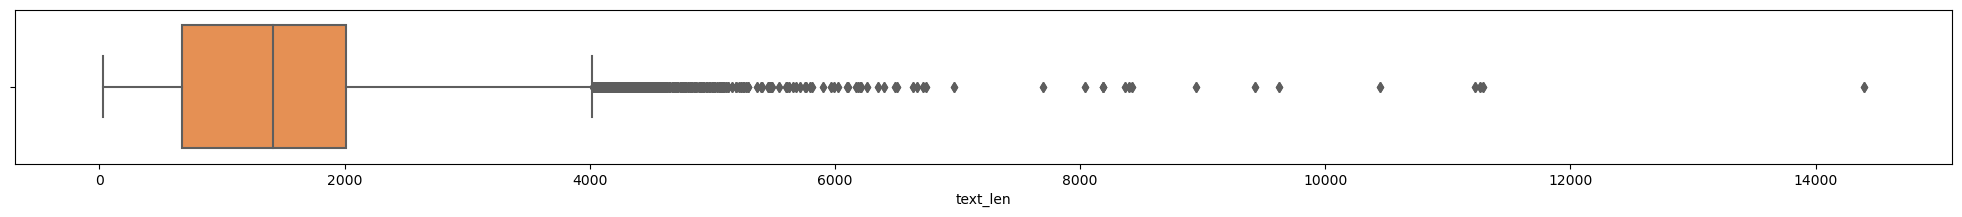

In [13]:
text_len = []

for idx, teks in enumerate(data['clean_text']):
    text_len.append(len(teks))

data['text_len'] = pd.DataFrame(text_len)

fig, axes = plt.subplots(figsize=(25, 2))
sns.boxplot(x=data['text_len'], palette="Oranges")

<Axes: xlabel='text_len'>

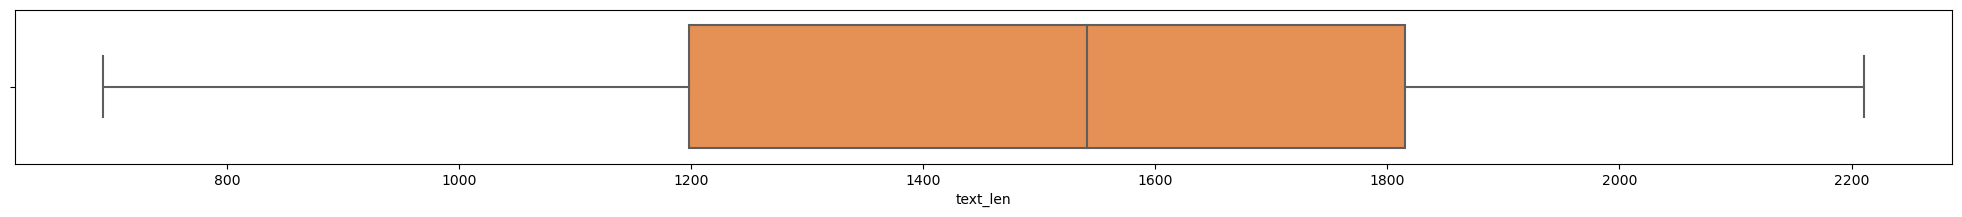

In [10]:
Q1 = data['text_len'].quantile(0.25)
Q3 = data['text_len'].quantile(0.75)
IQR = Q3 - Q1

data = data[(data['text_len'] > Q1) & (data['text_len'] < Q3)]

fig, axes = plt.subplots(figsize=(25, 2))
sns.boxplot(x=data['text_len'], palette="Oranges")

In [14]:
Counter(data['label'])

Counter({1: 21417, 0: 23481})

In [17]:
X = data['clean_text']
Y = data['label']
# Y = pd.get_dummies(df_filtered['label'])

X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size = 0.25)

In [18]:
vocab_size = 10000
embedding_dim = 1000
max_length = 4000
trunc_type = 'post'
padding_type = 'post'
oov_tok = "<OOV>"

In [19]:
# Tokenizing 
tokenizer = Tokenizer(num_words=vocab_size, oov_token=oov_tok)
tokenizer.fit_on_texts(X)

# Text to Sequences
training_sequences = tokenizer.texts_to_sequences(X_train)
testing_sequences = tokenizer.texts_to_sequences(X_test)

# Add padding
training_padded = pad_sequences(training_sequences, maxlen=max_length, padding = padding_type)
testing_padded = pad_sequences(testing_sequences, maxlen=max_length, padding = padding_type)

# Convert to numpy array
training_padded = np.array(training_padded)
training_label = np. array(y_train)

testing_padded = np.array(testing_padded)
testing_label = np. array(y_test)

In [20]:
word_index = tokenizer.word_index
len(word_index)
# vocab_size = len(tokenizer.word_index)+1

203565

In [21]:
def DNN_Model():
    model = Sequential()
    model.add(Embedding(input_dim=vocab_size, output_dim=embedding_dim, input_length=max_length))
    model.add(GlobalAveragePooling1D())

    model.add(Dense(512, kernel_regularizer=keras.regularizers.l2(l=0.1)))
    model.add(LeakyReLU(0.2))
    model.add(Dropout(0.5))
    model.add(BatchNormalization())

    model.add(Dense(128, kernel_regularizer=keras.regularizers.l2(l=0.1)))
    model.add(LeakyReLU(0.2))
    model.add(Dropout(0.5))
    model.add(BatchNormalization())


    # model.add(Dense(2, activation='softmax'))
    model.add(Dense(1, activation='sigmoid'))
    return model

def LSTM_Model():
    model = Sequential()
    model.add(Embedding(input_dim=vocab_size, output_dim=embedding_dim, input_length=max_length))
    model.add(LSTM(32))
    model.add(Dropout(0.5))
    # model.add(Dense(32, activation='relu'))
    # model.add(Dropout(0.5))
    # model.add(Dense(16, activation='relu'))
    model.add(Dense(2, activation='sigmoid'))
    return model

def GRU_Model():
    model = Sequential()
    model.add(Embedding(vocab_size, embedding_dim, input_length=max_length))
    model.add(GRU(units=32))
    model.add(Dense(units=1))
    return model

def CuDNNGRU_Model():
    sequences = layers.Input(shape=(max_length,))
    embedded = layers.Embedding(vocab_size, 64)(sequences)
    x = layers.CuDNNGRU(128, return_sequences=True)(embedded)
    x = layers.CuDNNGRU(128)(x)
    x = layers.Dense(32, activation='relu')(x)
    x = layers.Dense(100, activation='relu')(x)
    predictions = layers.Dense(1, activation='sigmoid')(x)
    model = models.Model(inputs=sequences, outputs=predictions)
    return model
    


model = DNN_Model()
# model = LSTM_Model()
# model = GRU_Model()
# model = CuDNNGRU_Model()
# model = RNN_Model()

model.compile(loss='mse', optimizer='adam', metrics=['binary_accuracy'])
# model.compile(loss='mse', optimizer='adam', metrics=['categorical_accuracy'])
# model.compile(loss='binary_crossentropy', optimizer='nadam', metrics=['accuracy'])
# model.compile(loss='binary_crossentropy', optimizer='rmsprop', metrics=['binary_accuracy'])
# model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['categorical_accuracy'])

In [22]:
num_epoch = 10
history = model.fit(training_padded, training_label, 
                    batch_size=64, epochs=num_epoch, 
                    validation_split=0.1)

Epoch 1/10
474/474 [==============================] - 33s 67ms/step - loss: 4.1848 - binary_accuracy: 0.5640 - val_loss: 0.2673 - val_binary_accuracy: 0.6277
Epoch 2/10
474/474 [==============================] - 32s 67ms/step - loss: 0.0917 - binary_accuracy: 0.9374 - val_loss: 0.0498 - val_binary_accuracy: 0.9828
Epoch 3/10
474/474 [==============================] - 32s 67ms/step - loss: 0.0588 - binary_accuracy: 0.9651 - val_loss: 0.0718 - val_binary_accuracy: 0.9507
Epoch 4/10
474/474 [==============================] - 32s 67ms/step - loss: 0.0621 - binary_accuracy: 0.9674 - val_loss: 0.0478 - val_binary_accuracy: 0.9828
Epoch 5/10
474/474 [==============================] - 32s 67ms/step - loss: 0.0572 - binary_accuracy: 0.9727 - val_loss: 0.1437 - val_binary_accuracy: 0.8596
Epoch 6/10
474/474 [==============================] - 32s 67ms/step - loss: 0.0561 - binary_accuracy: 0.9732 - val_loss: 0.0511 - val_binary_accuracy: 0.9834
Epoch 7/10
474/474 [==============================] 

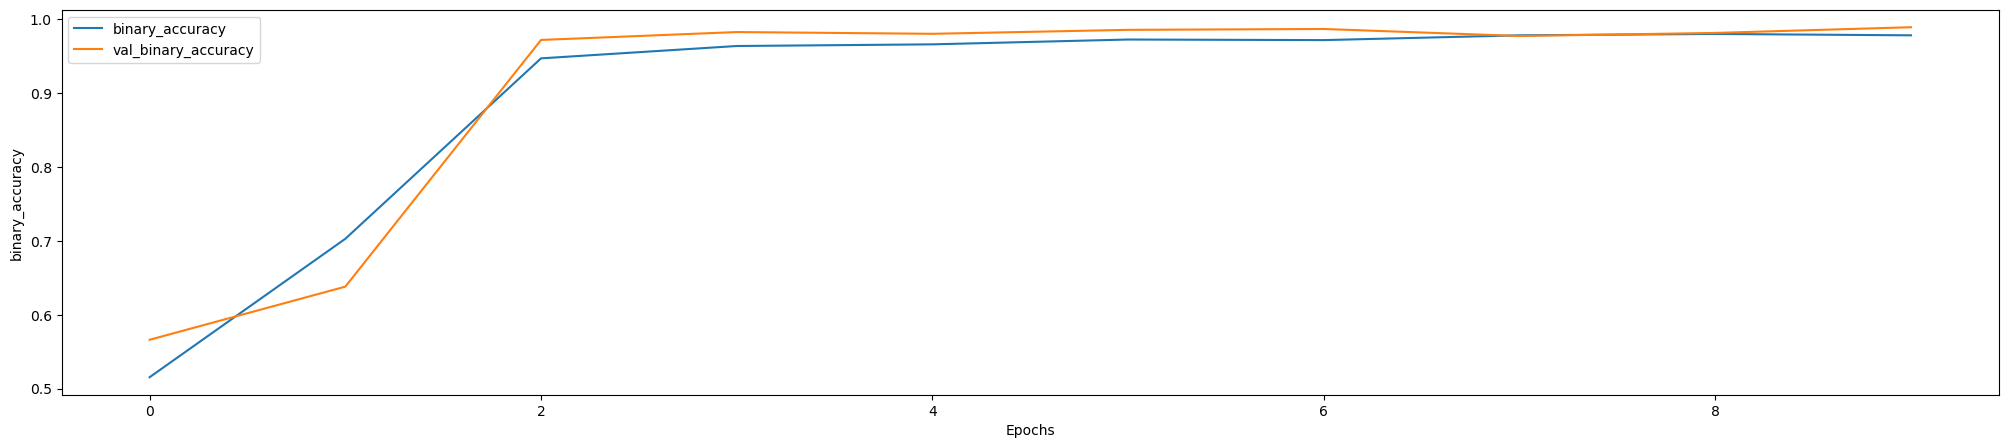

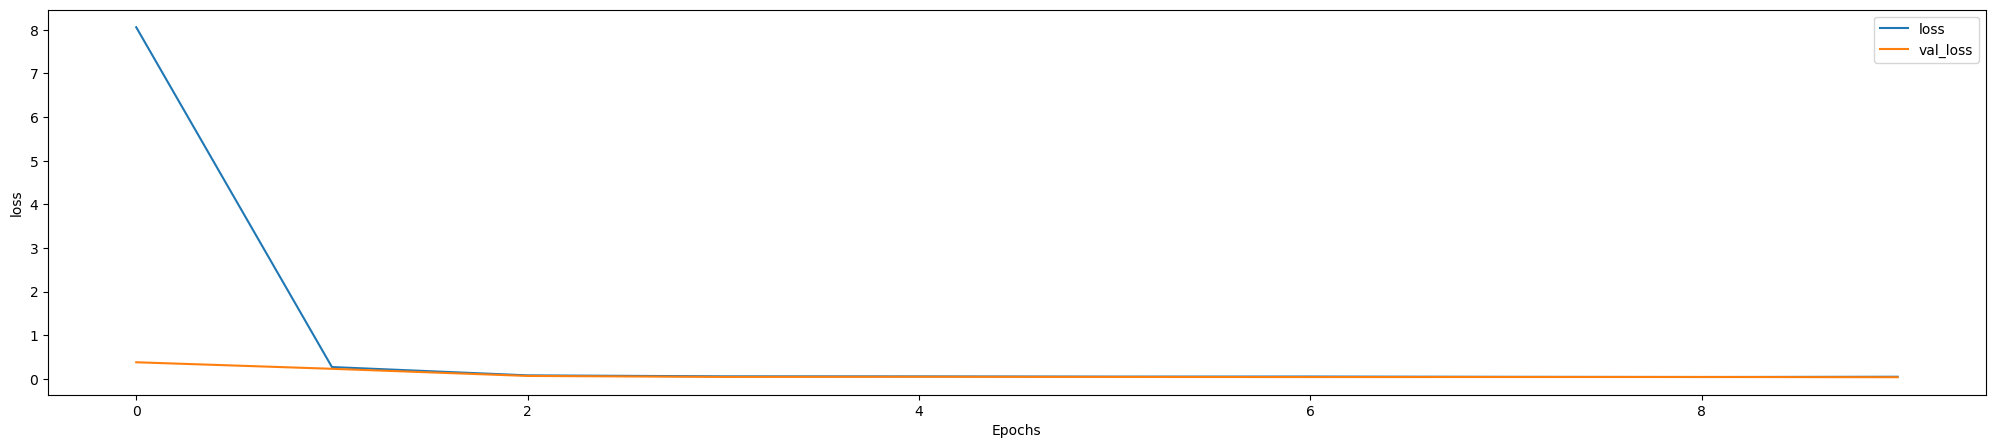

In [20]:
def plot_graphs(history, string):
    plt.subplots(figsize=(25, 5))
    plt.plot(history.history[string])
    plt.plot(history.history['val_'+string])
    plt.xlabel("Epochs")
    plt.ylabel(string)
    plt.legend([string, 'val_' + string])
    plt.show()

plot_graphs(history, "binary_accuracy")
plot_graphs(history, "loss")